# Nonlinear Kalman filtering

In this demo, we will look at dynamical systems with nonlinear state transitions. We will start with a one-dimensional problem; the number of rabbits on an island. This problem seems overly simple, but it is a good way to demonstrate the basic pipeline of working with ForneyLab. The second problem, that of tracking a pendulum, is a bit more realistic in that we translate a differential equation in state-space model form to a probabilistic model. This requires more effort on the part of model specification, but not too much on the part of inference.

## 1. Rabbit population size

We consider a model for the number of rabbits on a particular island. We assume the population size follows a [logistic map](https://en.wikipedia.org/wiki/Logistic_map): initially, it grows exponentially, but as the number of rabbits increases, so does the number of foxes. At some point, population size will drop again. But as the number of rabbits drops, so does the number of foxes, which means the number of rabbits can grow again. We express the change in the population with the following nonlinear state transition:

$$x_{t+1} = r \cdot x_t(1-x_t)$$

where $r$ is a fertility parameter, reflecting how fast the number of rabbits can grow. $x$ does not reflect the number of rabbits, but rather the proportion of rabbits relative to a maximum population $N$ on the island. This means $x$ is bounded in the interval $[0,1]$.

Every month, we count the number of rabbits $y_t$. We assume that these counts are noisy: sometimes, we count one rabbit twice and sometimes, we miss one. This noise is expressed as a Gaussian distribution centered at $0$, with some measurement noise precision.

In [1]:
# Import libraries to julia workspace
using ForneyLab
using ProgressMeter
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


### Generate data

We start by generating a dataset for a rabbit population with a maximum population $N$ and a particular fertility $r$. Note that there are different regimes for different values of $r$ (see [wiki](https://en.wikipedia.org/wiki/Logistic_map)). Here we will look at the simplest cases; when $r$ is between $0$ and $4$.

In [2]:
# Length of time-series
T = 36

# Maximum population size
N = 100

# Fertility parameter (0 < r < 4)
fertility = 3.2

# Measurement noise
noise = 0.1

# Initial proportion of rabbits
x0 = 0.02

# Initialize data array
states = zeros(T,)
observations = zeros(T,)

# Initialize previous state variable
prev_state = x0

for t = 1:T
    
    # State transition
    states[t] = fertility*prev_state*(1-prev_state)
    
    # Observation likelihood
    observations[t] = max(round(N*(states[t] + noise*randn(1)[1])), 0.)
    
    # Update "previous state"
    prev_state = states[t]
    
end    

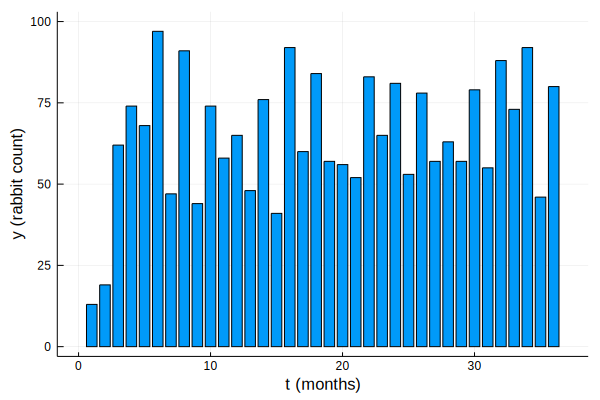

In [3]:
# Inspect data
bar(1:T, observations, ylims=[0, N], xlabel="t (months)", ylabel="y (rabbit count)", label="")

### Model specification

We define a state-space model, consisting of a state transition between $x_{t-1}$ and $x_t$ and an observation likelihood between $y_t$ and $x_t$. These are conditional distributions, which we model with certain parametric distributions. In this case, mostly Gaussian distributions.

- The states are the proportion of rabbits relative to a maximum N. To model the rabbit counts, we must multiply the states with the maximum population number $N$. Furthermore, we said that the rabbit counts are noisy (see 'Generate data' section). We assumed that we were counting some rabbits twice and missed others. That justifies using a white noise term: the current rabbit count is Gaussian distributed centered on the current state times the maximum population. For the sake of simplicity in this demo, we assume that we know the size of the noise. It is however straightforward to add a prior for measurement noise and estimate it simultaneously.

- The state transition that we defined above (the [logistic map](https://en.wikipedia.org/wiki/Logistic_map)) is nonlinear in nature (polynomial order 2). To capture this mapping, we have to use a "Nonlinear" node. The "Nonlinear{Unscented}" node performs an unscented transform to approximate the given function (exact up to polynomial order 3) and approximates the result with a Gaussian distribution.

- We have to specify a prior distribution for the states. Below, we choose a Gaussian distribution, but this is actually not completely valid. In a model using the logistic map, the states are confined to the interval $[0, 1]$. We would therefore have to use a bounded distribution, such as the [Beta](https://en.wikipedia.org/wiki/Beta_distribution). However, a Beta process is much more complicated than a Gaussian process and we will therefore avoid it here.

- We have to specify a prior for the fertility parameter $r$. It is supposed to be a strictly positive number, so ideally we would use something like a [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) or [log-Normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution. However, this, again, complicates inference and we have therefore opted for a Gaussian distribution.

We are going to specify the state-space model in recursive form, i.e. we only specify the previous state, the state transition and the likelihood, and update estimates as observations arrive. We will probably observe that our estimates start out relatively poor but improve over time. 

In [4]:
# Start model specification
fg = FactorGraph()

# Prior for fertility parameter
@RV r ~ GaussianMeanVariance(placeholder(:m_r), placeholder(:v_r), id=:r)

# Define previous state
@RV x_tmin1 ~ GaussianMeanVariance(placeholder(:m_x), placeholder(:v_x), id=:x_tmin1)

# State transition
g(x_tmin1, r) = r*x_tmin1*(1-x_tmin1)
@RV x_t ~ Nonlinear{Unscented}(x_tmin1, r; g=g, id=:x_t)

# Observation likelihood
@RV y_t ~ GaussianMeanVariance(N*x_t, noise, id=:y_t)

# Tell ForneyLab that variable y_t will be observed later on
placeholder(y_t, :y_t);

### Compile inference algorithm

The message passing algorithm, including a procedure for evaluating the free energy, can be derived automatically.

In [5]:
# Define sum-product message passing procedure with state x_t and fertility r as parameters of interest
algo = messagePassingAlgorithm([x_t, r], free_energy=true)

# Compile message passing procedure to an inference algorithm
code = algorithmSourceCode(algo, free_energy=true);

# Import compiled functions to workspace
eval(Meta.parse(code));

# Print compiled functions (uncomment if desired)
# println(code)

### Execute inference algorithm

We execute the algorithm in an online fashion, where after each timestep the posteriors for the state and fertility parameter are used as priors for the next timestep.

In [6]:
# Parameters for prior distributions
m_x_0 = 0.5
v_x_0 = 2.0
m_r_0 = 1.0
v_r_0 = 1.0

# Initialize array to track Free Energy objective
F = zeros(T,)

# Initialize arrays for storing parameter estimates
m_x_t = zeros(T,)
v_x_t = zeros(T,)
m_r_t = zeros(T,)
v_r_t = zeros(T,)

# Initialize previous parameter estimates
m_x_tmin1 = m_x_0
v_x_tmin1 = v_x_0
m_r_tmin1 = m_r_0
v_r_tmin1 = v_r_0

# Start progress bar
progress_bar = Progress(T, 1, "Progress: ")

# Recursive estimation procedure (posteriors at time t are priors for time t+1)
for t = 1:T
    
    # Update progress bar
    update!(progress_bar, t)
    
    # Store data for current time-step
    data = Dict(:y_t => observations[t],
                :m_x => m_x_tmin1,
                :v_x => v_x_tmin1,
                :m_r => m_r_tmin1,
                :v_r => v_r_tmin1)

    # Estimate marginal distributions of interest (x_t and r)
    marginals = step!(data)
    
    # Evaluate free energy
    F[t] = freeEnergy(data, marginals) 
    
    # Extract parameters of estimated marginal distributions
    (m_x, v_x) = ForneyLab.unsafeMeanCov(marginals[:x_t])
    (m_r, v_r) = ForneyLab.unsafeMeanCov(marginals[:r])
    
    # Reset parameter estimate arrays for next time-step
    m_x_tmin1 = m_x_t[t] = m_x
    v_x_tmin1 = v_x_t[t] = v_x
    m_r_tmin1 = m_r_t[t] = m_r
    v_r_tmin1 = v_r_t[t] = v_r
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


### Inspect Results

We will first visualize the estimated states. Since this is a probabilistic model, we can show the uncertainty of the estimates at the same time.

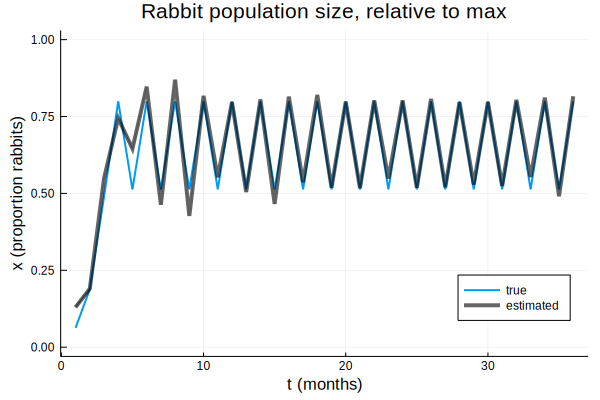

In [7]:
# Plot true states and overlay estimates
plot(1:T, states, linewidth=2, ylims=[0., 1.], xlabel="t (months)", ylabel="x (proportion rabbits)", label="true", legend=:bottomright)
plot!(1:T, m_x_t, linewidth=4, color="black", ribbon=[sqrt.(v_x_t) sqrt.(v_x_t)], alpha=0.6, label="estimated")
title!("Rabbit population size, relative to max")

Next, we can plot the estimate of the fertility parameter over time. It should vary a bit at the start, but converge towards the end.

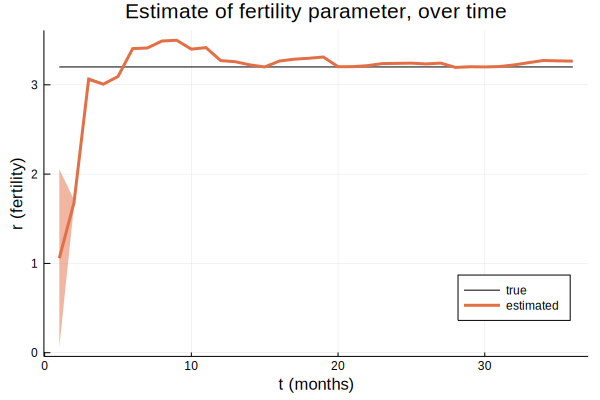

In [8]:
# Plot estimate of fertility parameter r
plot(1:T, fertility.*ones(T,), color="black", label="true", legend=:bottomright)
plot!(1:T, m_r_t, ribbon=[sqrt.(v_r_t) sqrt.(v_r_t)], linewidth=3, xlabel="t (months)", ylabel="r (fertility)", label="estimated")
title!("Estimate of fertility parameter, over time")

We tracked free energy for each observation, so we can show how it evolves over time. Note that free energy is a measure of prediction error, weighted by how uncertain the model is about its prediction.

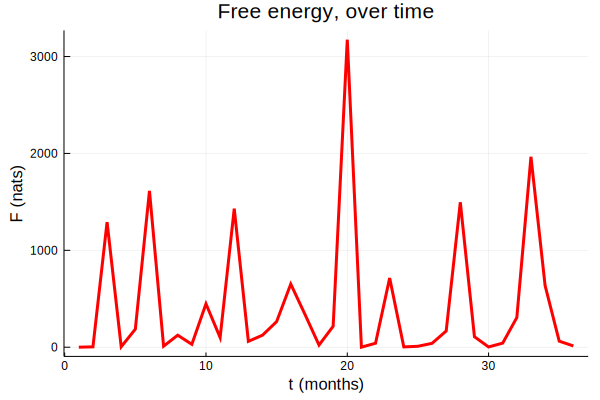

In [9]:
# Plot free energy objective
plot(1:T, F, linewidth=3, color="red", xlabel="t (months)", ylabel="F (nats)", label="")
title!("Free energy, over time")

## 2. Tracking a noisy pendulum

In this problem, we will be tracking a pendulum whose observations are noisy. You can find this example in [Bayesian Filtering & Smoothing](https://www.cambridge.org/core/books/bayesian-filtering-and-smoothing/C372FB31C5D9A100F8476C1B23721A67) by Simon Särkkä (Ex 3.7). Its state transitions are sinusoidal in nature and it hence, qualifies as a nonlinear dynamical system. We can describe the system with the following differential equation:

$$\begin{align}
\frac{d}{dt} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} x_2 \\ -g \sin(x_1) \end{bmatrix}
\end{align}$$

where $x_1$ represents the angle $\alpha$ of the pendulum, $x_2$ represents the change in angle $d \alpha /dt$ and $g$ is gravitational acceleration. We discretise the equation using a forward finite difference: $dx/dt = (x_{t+1} - x_{t})/\Delta t$. This produces the following discrete state transition:

$$\begin{align}
\begin{bmatrix} x_{1,t+1} \\ x_{2,t+1} \end{bmatrix} = \begin{bmatrix} x_{1,t} + x_{2,t}\Delta t \\ x_{2,t} - g \sin(x_{1,t})\Delta t \end{bmatrix}
\end{align}$$

We cannot observe the change in angle directly, only the angle itself (i.e. $x_{1}$). We can select the first element of the state vector by taking the inner product between the vector $[1 \ 0]$ and the state vector $x_t$. The observation is corrupted by white noise $v_t$:

$$y_t = x_{1,t} + v_t$$

where $v_t \sim \mathcal{N}(0, \tau^{-1})$.

### Generate data

In [10]:
# Length of time-series
T = 500
Δt = 0.01

# Gravitational acceleration
G = 9.81

# Noise
measurement_noise = 0.05

# Initial states
x0 = [1.0, 0.0]

# Initialize data array
states = zeros(2,T)
observations = zeros(T,)

# Initialize previous state variable
prev_state = x0

for t = 1:T
    
    # State transition
    states[1,t] = prev_state[1] + prev_state[2]*Δt
    states[2,t] = prev_state[2] - G*sin(prev_state[1])*Δt
    
    # Observation likelihood
    observations[t] = states[1,t] + sqrt(measurement_noise)*randn(1)[1]
    
    # Update "previous state"
    prev_state = states[:,t]
    
end    

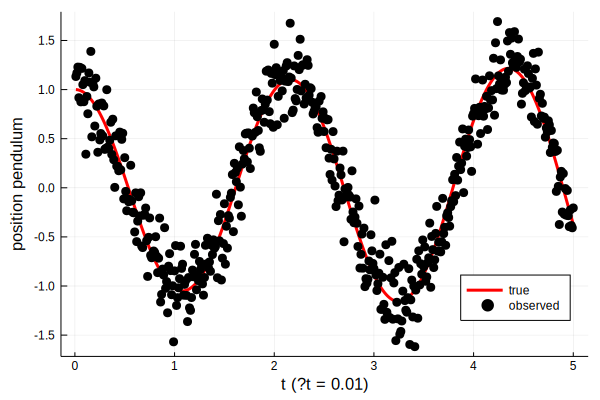

In [11]:
# Inspect data
plot((1:T).*Δt, states[1,:], linewidth=3, color="red", xlabel="t (Δt = "*string(Δt)*")", ylabel="position pendulum", label="true", legend=:bottomright)
scatter!((1:T).*Δt, observations, color="black", xlabel="t (Δt = "*string(Δt)*")", ylabel="position pendulum", label="observed")

### Model specification

We will once again define distributions for the state transition and likelihood. This time, we will assume that we don't know the precision parameter $\tau$ of measurement noise $v_t$. Since $\tau$ is a strictly positive parameter, we need to use an appropriate distribution. The Gamma distribution is [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior) to the Gaussian likelihood function and will make computation easier.

In [12]:
# Start model specification
fg = FactorGraph()

# Prior for measurement noise precision
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))

# Define previous state
@RV x_tmin1 ~ GaussianMeanVariance(placeholder(:m_x, dims=(2,)), placeholder(:v_x, dims=(2,2)), id=:x_tmin1)

# State transition
g(x) = [x[1] + x[2]*Δt, x[2] - G*sin(x[1])*Δt]
@RV x_t ~ Nonlinear{Unscented}(x_tmin1; g=g, alpha=0.01, id=:x_t)

# Mask the state variable
@RV x_1 = dot([1., 0.], x_t)

# Observation likelihood
@RV y_t ~ GaussianMeanPrecision(x_1, τ, id=:y_t)

# Tell ForneyLab that variable y_t will be observed later on
placeholder(y_t, :y_t);

### Compile inference algorithm

We cannot use exact Bayesian inference here and will therefore switch to an approximate inference scheme: variational message passing.

In [13]:
# Define a variational message passing procedure
algo = messagePassingAlgorithm(x_t, τ, ids=[:x, :τ], free_energy=true)

# Compile message passing procedure to an inference algorithm
code = algorithmSourceCode(algo, free_energy=true);

# Import compiled functions to workspace
eval(Meta.parse(code));

# Print compiled functions (uncomment when desired)
# println(code)

### Execute inference algorithm

This piece of code is similar to the previous problem. The only difference is that variational message passing is an optimization problem: we defined a "recognition" distribution that approximates the posterior distributions of interest. We have to perform a few iterations of coordinate descent to minimize the KL-divergence between the approximating recognition distribution and the true generative model.

In [14]:
# Number of iterations
num_iterations = 3

# Parameters for prior distributions
m_x_0 = [0., 0.]
v_x_0 = [1. 0.;0. 1.]
a_τ_0 = 0.05
b_τ_0 = 1.0

# Initialize array to track Free Energy objective
F = zeros(T,num_iterations)

# Initialize arrays for storing parameter estimates
m_x_t = zeros(2,T)
v_x_t = zeros(2,2,T)
a_τ_t = zeros(T,)
b_τ_t = zeros(T,)

# Initialize previous parameter estimates
m_x_tmin1 = m_x_0
v_x_tmin1 = v_x_0
a_τ_tmin1 = a_τ_0
b_τ_tmin1 = b_τ_0

# Initialize marginal distributions
marginals = Dict()
marginals[:x_tmin1] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[1.,0.], v=[1. 0.;0. 1.])
marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=[1.,0.], v=[1. 0.;0. 1.])
marginals[:x_1] = ProbabilityDistribution(Univariate, GaussianMeanVariance, m=0., v=1.)
marginals[:τ] = ProbabilityDistribution(Univariate, Gamma, a=0.1, b=1.)

# Start progress bar
progress_bar = Progress(T, 1, "Progress: ")

# Recursive estimation procedure (posteriors at time t are priors for time t+1)
for t = 1:T
    
    # Update progress bar
    update!(progress_bar, t)
    
    # Store data for current time-step
    data = Dict(:y_t => observations[t],
                :m_x => m_x_tmin1,
                :v_x => v_x_tmin1,
                :a_τ => a_τ_tmin1,
                :b_τ => b_τ_tmin1)
    
    # Iteratively update beliefs
    for tt = 1:num_iterations
        
        # Evaluate free energy
        F[t,tt] = freeEnergy(data, marginals) 
        
        # Update recognition distribution for current state
        stepx!(data, marginals)
                
        # Update recognition distribution for measurement noise precision
        stepτ!(data, marginals)
        
    end
    
    # Extract parameters of estimated marginal distributions
    (m_x, v_x) = ForneyLab.unsafeMeanCov(marginals[:x_t])
    (a_τ, b_τ) = values(marginals[:τ].params)
    
    # Reset parameter estimate arrays for next time-step
    m_x_tmin1 = m_x_t[:,t] = m_x
    v_x_tmin1 = v_x_t[:,:,t] = v_x
    a_τ_tmin1 = a_τ_t[t] = a_τ
    b_τ_tmin1 = b_τ_t[t] = b_τ
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


### Inspect results

We can plot the estimates of the angle and the change in the angle, over time, including the uncertainty of the estimates.

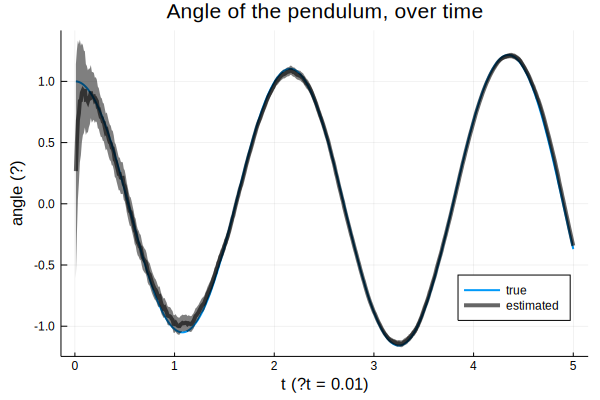

In [15]:
# Plot true states and overlay estimates
plot((1:T).*Δt, states[1,:], linewidth=2, xlabel="t (Δt = "*string(Δt)*")", ylabel="angle (α)", label="true", legend=:bottomright)
plot!((1:T).*Δt, m_x_t[1,:], linewidth=4, color="black", ribbon=[sqrt.(v_x_t[1,1,:]) sqrt.(v_x_t[1,1,:])], alpha=0.6, label="estimated")
title!("Angle of the pendulum, over time")

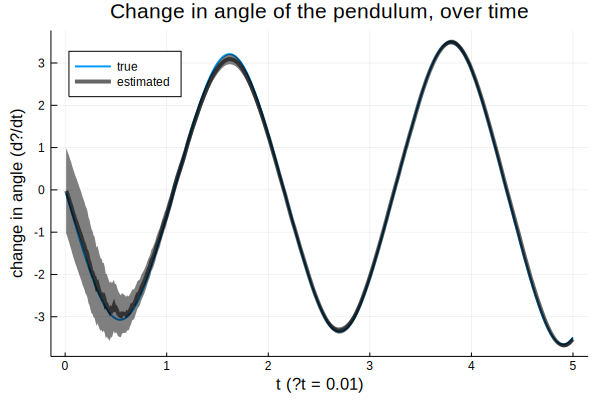

In [16]:
# Plot true states and overlay estimates
plot((1:T).*Δt, states[2,:], linewidth=2, xlabel="t (Δt = "*string(Δt)*")", ylabel="change in angle (dα/dt)", label="true", legend=:topleft)
plot!((1:T).*Δt, m_x_t[2,:], linewidth=4, color="black", ribbon=[sqrt.(v_x_t[2,2,:]) sqrt.(v_x_t[2,2,:])], alpha=0.6, label="estimated")
title!("Change in angle of the pendulum, over time")

We left measurement noise precision as an unknown parameter. You will notice below that the model increasingly over-estimates this precision.

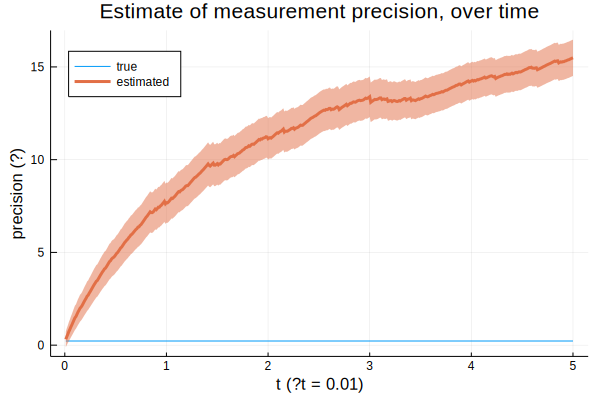

In [17]:
# Mean and variance of gamma distribution
m_τ_t = a_τ_t ./ b_τ_t
v_τ_t = a_τ_t ./ b_τ_t.^2

# Plot estimate of τ
plot((1:T).*Δt, ones(T,)*sqrt(measurement_noise), label="true", legend=:topleft)
plot!((1:T).*Δt, m_τ_t, ribbon=[sqrt.(v_τ_t) sqrt.(v_τ_t)], linewidth=3, xlabel="t (Δt = "*string(Δt)*")", ylabel="precision (τ)", label="estimated")
title!("Estimate of measurement precision, over time")

It is important to look at the evolution of free energy. Remember that free energy is a measure of uncertainty-weighted prediction error. 

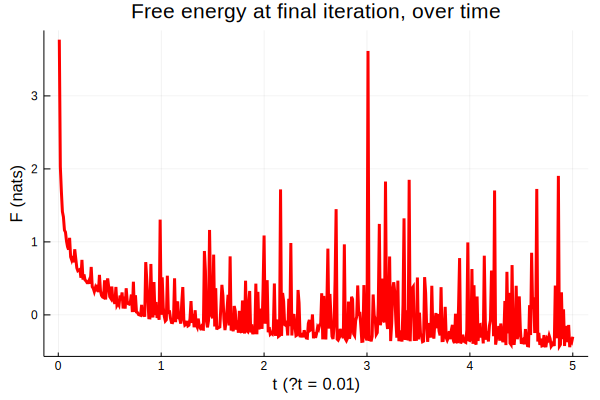

In [18]:
# Plot free energy objective
plot((1:T).*Δt, F[:,end], linewidth=3, color="red", xlabel="t (Δt = "*string(Δt)*")", ylabel="F (nats)", label="")
title!("Free energy at final iteration, over time")

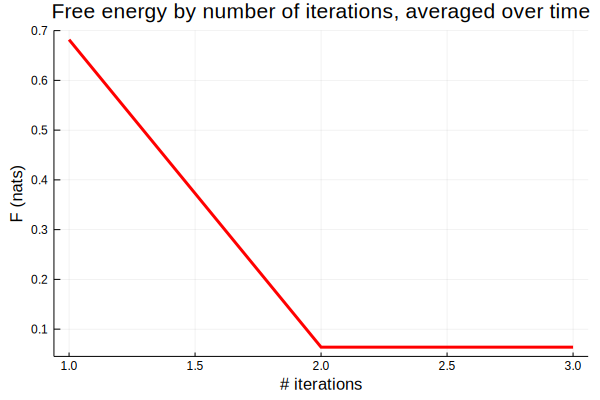

In [19]:
# Plot free energy objective
plot(1:num_iterations, mean(F, dims=1)', linewidth=3, color="red", xlabel="# iterations", ylabel="F (nats)", label="")
title!("Free energy by number of iterations, averaged over time")